데이터 전처리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import konlpy
from konlpy.tag import Okt
import numpy as np

In [2]:
train_data=pd.read_csv('D:\\ai\\기말대체\\Data set_1.csv')
test_data=pd.read_csv('D:\\ai\\기말대체\\Data set_2.csv')

In [3]:
stopwords=['로','에','등','으로','및','과','되며','한']

In [4]:
okt=Okt()
X_train=[]
for sentence in train_data['title']:
    temp_X=[]
    temp_X=okt.morphs(sentence,stem=True)
    temp_X=[word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)
X_test=[]
for sentence in test_data['title']:
    temp_X=[]
    temp_X=okt.morphs(sentence,stem=True)
    temp_X=[word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [5]:
print(X_train[:3])

[['CMG', '제약', '외국인', '12만', '9000', '주', '순', '매수', '주가', '058'], ['CMG', '제약', '외국인', '8만', '6000', '주', '순', '매수', '주가', '246'], ['CMG', '제약', '검색', '상위', '랭킹', '주가', '159']]


In [6]:
print(X_test[:3])

[['fnRASSI', '씨', '케이', '에이치', '900120', '1185', '상승'], ['fnRASSI', '씨', '케이', '에이치', '900120', '899', '상승'], ['코스닥', '人', '씨', '케이', '에이치', '화장품', '·', '건기', '식', '사업', '두', '마리', '토끼', '잡다']]


토큰화한 단어를 정수인코딩

In [7]:
from keras.preprocessing.text import Tokenizer
max_words=35000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


In [8]:
print(X_train[:3])

[[105, 70, 22, 858, 583, 8, 18, 20, 4, 859], [105, 70, 22, 860, 584, 8, 18, 20, 4, 585], [105, 70, 44, 50, 51, 4, 445]]


In [9]:
print(X_test[:3])

[[12, 66, 180, 202, 1897, 1], [12, 66, 180, 202, 1897, 1], [35, 66, 180, 202, 763, 5, 662, 65, 1292]]


label data -1,0,1에 대해서 one hot encoding

In [10]:
y_train=[]
y_test=[]

for i in range(len(train_data['label'])):
    if train_data['label'].iloc[i]==1:
        y_train.append([0,0,1])
    elif train_data['label'].iloc[i]==0:
        y_train.append([0,1,0])
    elif train_data['label'].iloc[i]==-1:
        y_train.append([1,0,0])

for i in range(len(test_data['label'])):
    if test_data['label'].iloc[i]==1:
        y_test.append([0,0,1])
    elif test_data['label'].iloc[i]==0:
        y_test.append([0,1,0])
    elif test_data['label'].iloc[i]==-1:
        y_test.append([1,0,0])
        
y_train=np.array(y_train)
y_test=np.array(y_test)

In [11]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [12]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

optimizer adam->sgd

In [13]:
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping

np.random.seed(3)
tf.random.set_seed(3)

max_len=20
X_train=pad_sequences(X_train, maxlen=max_len)
X_test=pad_sequences(X_test,maxlen=max_len)

In [17]:
model4 = Sequential()
model4.add(Embedding(max_words,100))
model4.add(LSTM(128)) #layer에 포함되는 unit개수가 128개일때 대체로 괜찮은가보다
model4.add(Dense(3, activation='softmax'))  # 활성화 함수 softmax 사용

model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [23]:
# 모델 저장 폴더 만들기
import os
MODEL_DIR = './model4_save/'
if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

In [24]:
#파일명에 epoch와 val_loss를 기록하도록 설정 
modelpath="./model4_save/{epoch:02d}-{val_loss:.4f}.hdf5" 

# 모델 업데이트 및 저장
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

In [25]:
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

In [26]:
hist4 = model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3000, verbose=2, callbacks=[checkpointer,early_stopping_callback])

Train on 946 samples, validate on 949 samples
Epoch 1/3000
 - 1s - loss: 0.9066 - accuracy: 0.4915 - val_loss: 0.8608 - val_accuracy: 0.4721

Epoch 00001: val_loss improved from inf to 0.86079, saving model to ./model4_save/01-0.8608.hdf5
Epoch 2/3000
 - 1s - loss: 0.8945 - accuracy: 0.4926 - val_loss: 0.8463 - val_accuracy: 0.4721

Epoch 00002: val_loss improved from 0.86079 to 0.84629, saving model to ./model4_save/02-0.8463.hdf5
Epoch 3/3000
 - 1s - loss: 0.8864 - accuracy: 0.4915 - val_loss: 0.8359 - val_accuracy: 0.4721

Epoch 00003: val_loss improved from 0.84629 to 0.83594, saving model to ./model4_save/03-0.8359.hdf5
Epoch 4/3000
 - 1s - loss: 0.8808 - accuracy: 0.4915 - val_loss: 0.8285 - val_accuracy: 0.4721

Epoch 00004: val_loss improved from 0.83594 to 0.82846, saving model to ./model4_save/04-0.8285.hdf5
Epoch 5/3000
 - 1s - loss: 0.8773 - accuracy: 0.4915 - val_loss: 0.8225 - val_accuracy: 0.4721

Epoch 00005: val_loss improved from 0.82846 to 0.82251, saving model to ./

 - 1s - loss: 0.7327 - accuracy: 0.6818 - val_loss: 0.7285 - val_accuracy: 0.6502

Epoch 00045: val_loss improved from 0.73174 to 0.72846, saving model to ./model4_save/45-0.7285.hdf5
Epoch 46/3000
 - 1s - loss: 0.7290 - accuracy: 0.6744 - val_loss: 0.7621 - val_accuracy: 0.6322

Epoch 00046: val_loss did not improve from 0.72846
Epoch 47/3000
 - 1s - loss: 0.7248 - accuracy: 0.6839 - val_loss: 0.7419 - val_accuracy: 0.6417

Epoch 00047: val_loss did not improve from 0.72846
Epoch 48/3000
 - 1s - loss: 0.7211 - accuracy: 0.6797 - val_loss: 0.7115 - val_accuracy: 0.6702

Epoch 00048: val_loss improved from 0.72846 to 0.71146, saving model to ./model4_save/48-0.7115.hdf5
Epoch 49/3000
 - 1s - loss: 0.7181 - accuracy: 0.6818 - val_loss: 0.7382 - val_accuracy: 0.6586

Epoch 00049: val_loss did not improve from 0.71146
Epoch 50/3000
 - 1s - loss: 0.7133 - accuracy: 0.6860 - val_loss: 0.7308 - val_accuracy: 0.6660

Epoch 00050: val_loss did not improve from 0.71146
Epoch 51/3000
 - 1s - loss


Epoch 00096: val_loss improved from 0.48288 to 0.46060, saving model to ./model4_save/96-0.4606.hdf5
Epoch 97/3000
 - 1s - loss: 0.4494 - accuracy: 0.8552 - val_loss: 0.6154 - val_accuracy: 0.7281

Epoch 00097: val_loss did not improve from 0.46060
Epoch 98/3000
 - 1s - loss: 0.4413 - accuracy: 0.8499 - val_loss: 0.4464 - val_accuracy: 0.8303

Epoch 00098: val_loss improved from 0.46060 to 0.44641, saving model to ./model4_save/98-0.4464.hdf5
Epoch 99/3000
 - 1s - loss: 0.4383 - accuracy: 0.8531 - val_loss: 0.4424 - val_accuracy: 0.8335

Epoch 00099: val_loss improved from 0.44641 to 0.44238, saving model to ./model4_save/99-0.4424.hdf5
Epoch 100/3000
 - 1s - loss: 0.4356 - accuracy: 0.8541 - val_loss: 0.4399 - val_accuracy: 0.8356

Epoch 00100: val_loss improved from 0.44238 to 0.43988, saving model to ./model4_save/100-0.4399.hdf5
Epoch 101/3000
 - 1s - loss: 0.4300 - accuracy: 0.8615 - val_loss: 0.4575 - val_accuracy: 0.8209

Epoch 00101: val_loss did not improve from 0.43988
Epoch

 - 1s - loss: 0.2462 - accuracy: 0.9239 - val_loss: 0.4051 - val_accuracy: 0.8535

Epoch 00147: val_loss did not improve from 0.36223
Epoch 148/3000
 - 1s - loss: 0.2412 - accuracy: 0.9271 - val_loss: 0.5024 - val_accuracy: 0.8272

Epoch 00148: val_loss did not improve from 0.36223
Epoch 149/3000
 - 1s - loss: 0.2355 - accuracy: 0.9271 - val_loss: 0.3937 - val_accuracy: 0.8567

Epoch 00149: val_loss did not improve from 0.36223
Epoch 150/3000
 - 1s - loss: 0.2485 - accuracy: 0.9207 - val_loss: 0.4487 - val_accuracy: 0.8409

Epoch 00150: val_loss did not improve from 0.36223
Epoch 151/3000
 - 1s - loss: 0.2315 - accuracy: 0.9281 - val_loss: 0.4582 - val_accuracy: 0.8377

Epoch 00151: val_loss did not improve from 0.36223
Epoch 152/3000
 - 1s - loss: 0.2318 - accuracy: 0.9281 - val_loss: 0.3834 - val_accuracy: 0.8693

Epoch 00152: val_loss did not improve from 0.36223
Epoch 153/3000
 - 1s - loss: 0.2256 - accuracy: 0.9281 - val_loss: 0.4044 - val_accuracy: 0.8556

Epoch 00153: val_loss d

 - 1s - loss: 0.1258 - accuracy: 0.9440 - val_loss: 0.5335 - val_accuracy: 0.8525

Epoch 00202: val_loss did not improve from 0.36223
Epoch 203/3000
 - 1s - loss: 0.1366 - accuracy: 0.9387 - val_loss: 0.4750 - val_accuracy: 0.8672

Epoch 00203: val_loss did not improve from 0.36223
Epoch 204/3000
 - 1s - loss: 0.1397 - accuracy: 0.9397 - val_loss: 0.4387 - val_accuracy: 0.8693

Epoch 00204: val_loss did not improve from 0.36223
Epoch 205/3000
 - 1s - loss: 0.1253 - accuracy: 0.9450 - val_loss: 0.5551 - val_accuracy: 0.8472

Epoch 00205: val_loss did not improve from 0.36223
Epoch 206/3000
 - 1s - loss: 0.1375 - accuracy: 0.9397 - val_loss: 0.5063 - val_accuracy: 0.8430

Epoch 00206: val_loss did not improve from 0.36223
Epoch 207/3000
 - 1s - loss: 0.2409 - accuracy: 0.9207 - val_loss: 0.4386 - val_accuracy: 0.8672

Epoch 00207: val_loss did not improve from 0.36223
Epoch 208/3000
 - 1s - loss: 0.1272 - accuracy: 0.9408 - val_loss: 0.4443 - val_accuracy: 0.8714

Epoch 00208: val_loss d

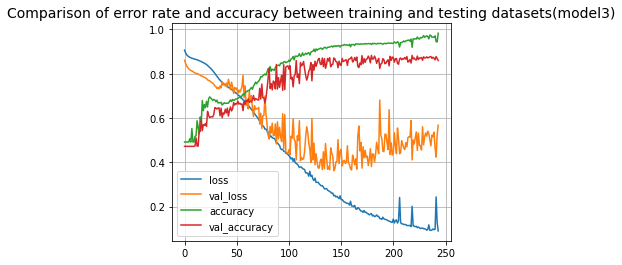

In [27]:
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_path="D:\\ai\\기말대체\\NanumFontSetup_TTF_GOTHIC\\NanumGothic.ttf"
#font_name = fm.FontProperties(fname=font_path).get_name()
#plt.rc('font', family=font_name, size=12) 
plt.figure(figsize=(5,4))
plt.title('Comparison of error rate and accuracy between training and testing datasets(model3)', fontsize=14)

plt.plot(hist4.history['loss'])      # 학습 데이터셋의 loss   -> loss 
plt.plot(hist4.history['val_loss'])  # 테스트 데이터셋의 loss -> val_loss

plt.plot(hist4.history['accuracy'])      # 학습 데이터셋의 accuracy    -> accuracy 
plt.plot(hist4.history['val_accuracy'])  # 테스트 데이터셋의 accuracy  -> val_accuracy 

plt.legend(['loss','val_loss','accuracy', 'val_accuracy' ])     # 범례
plt.grid()
plt.show()

In [28]:
model4.save('model4.h5')  

<h1>5_Deep learning results

In [37]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 3,617,635
Trainable params: 3,617,635
Non-trainable params: 0
_________________________________________________________________


In [30]:
predict=model4.predict(X_test)

In [31]:
predict_labels=np.argmax(predict, axis=1)
original_labels=np.argmax(y_test,axis=1)

In [36]:
for i in range(30): 
    print("제목 : ", test_data['title'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])

제목 :  fnRASSI씨케이에이치900120 1185 상승 /	 원래 라벨 :  2 /	예측한 라벨 :  2
제목 :  fnRASSI씨케이에이치900120 899 상승 /	 원래 라벨 :  2 /	예측한 라벨 :  2
제목 :  코스닥人씨케이에이치 화장품·건기식 사업 두마리 토끼 잡겠다 /	 원래 라벨 :  1 /	예측한 라벨 :  1
제목 :  fnRASSI씨케이에이치900120 전일대비 1967 상승 /	 원래 라벨 :  2 /	예측한 라벨 :  2
제목 :  제목 /	 원래 라벨 :  1 /	예측한 라벨 :  1
제목 :  특징주 아이에이 미래차 경쟁력 부각 전기차 등 친환경차 사업 수혜 기대 /	 원래 라벨 :  2 /	예측한 라벨 :  1
제목 :  fnRASSI아이에이 085 오르며 거래량 증가 /	 원래 라벨 :  1 /	예측한 라벨 :  1
제목 :  카이노스메드 52주 신고가 경신 글로벌 CNS 신약 개발사로의 도약 /	 원래 라벨 :  2 /	예측한 라벨 :  2
제목 :  카이노스메드 52주 신고가 경신 글로벌 CNS 신약 개발사로의 도약 /	 원래 라벨 :  2 /	예측한 라벨 :  2
제목 :  SK바이오팜 국내 유일 FDA 승인 CNS 치료제 보유 삼성증권 /	 원래 라벨 :  2 /	예측한 라벨 :  1
제목 :  자동차 전장 아이에이 1분기 영업익 22억 흑자 전환 /	 원래 라벨 :  2 /	예측한 라벨 :  1
제목 :  아이에이 26조원 양자암호통신 시장 선도양자진흥법 통과에 상승 /	 원래 라벨 :  2 /	예측한 라벨 :  1
제목 :  fnRASSI아이에이038880 1134 상승 /	 원래 라벨 :  2 /	예측한 라벨 :  1
제목 :  아이에이 10 이상 상승 전일 외국인 대량 순매수 /	 원래 라벨 :  2 /	예측한 라벨 :  2
제목 :  아이에이 中전기차 부품사업 기술료 47억 추가 수취 /	 원래 라벨 :  1 /	예측한 라벨 :  1
제목 :  아이에이 中전기차 부품 사업 기술료 47억원 추가 수취 /	

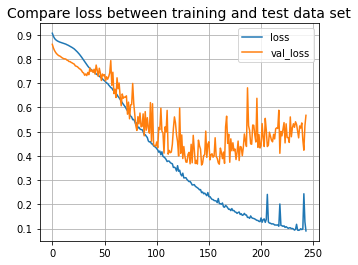

In [33]:
plt.figure(figsize=(5,4))
plt.title('Compare loss between training and test data set', fontsize=14)
plt.plot(hist4.history['loss'])      # 학습 데이터셋의 정확도
plt.plot(hist4.history['val_loss'])  # 테스트 데이터셋의 정확도
plt.legend(['loss','val_loss']) # 범례
plt.grid()
plt.show()

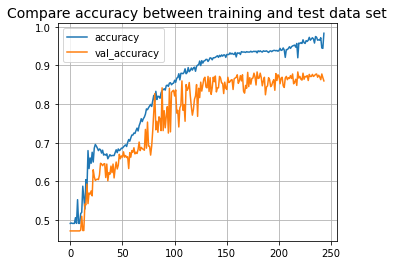

In [35]:
plt.figure(figsize=(5,4))
plt.title('Compare accuracy between training and test data set', fontsize=14)
plt.plot(hist4.history['accuracy'])      # 학습 데이터셋의 정확도
plt.plot(hist4.history['val_accuracy'])  # 테스트 데이터셋의 정확도
plt.legend(['accuracy','val_accuracy']) # 범례
plt.grid()
plt.show()